
Rastrigin: 2D


In [1]:
pip install pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Rastrigin'
n_test = 500
eps = 1e-08

util_grad_exact = 'dEI_GP'
util_grad_approx = 'ExpectedImprovement'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - Rastrigin(x) 2-D:

def objfunc(x1_training, x2_training):
        return  operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )
        
def objfunc_der(x1_training, x2_training):
        return  operator * (2 * x1_training + 20 * np.pi * np.sin(2 * np.pi * x1_training)
                                    + 2 * x2_training + 20 * np.pi * np.sin(2 * np.pi * x2_training)
                          )
    
# Constraints:
lb = -5.12 
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# True y bounds:
operator = -1
y_global_orig = 0 # targets global minimum

# Test data:
x1_test = np.linspace(lb, ub, n_test) 
x2_test = np.linspace(lb, ub, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [5]:
n_start_AcqFunc = iters*0 + 10


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def deriv_se(X, Xstar, sigmaf, l, sigman):
    return cdist(X, Xstar) / (l ** 2) * se(X, Xstar, sigmaf, l, sigman)

def der_covmat(X, Xstar, sigmaf, l, sigman):
      nx = len(X)
      ny = len(Xstar)
      return np.round(np.array([deriv_se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman) for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):
    l = GaussianProcess(cov_func, optimize=opt).getcovparams()['l']
    sigmaf = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigmaf']
    sigman = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigman']

    def AcqGrad(self, Xstar):
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.sigmaf, self.l, self.sigman).T
        
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds
        

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: Multistart changed to variable 'n_start_AcqFunc'

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        if self.n_jobs == 1:
            for index, start_point in enumerate(start_points_arr):
                res = minimize(self._acqWrapper, x0=start_point, method=method,
                               bounds=self.parameter_range)
                x_best[index], f_best[index] = res.x, np.atleast_1d(res.fun)[0]
        else:
            opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
            x_best = np.array([res.x for res in opt])
            f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.best = x_best[np.argmin(f_best)]

In [10]:
## dGPGO:

grad = 0

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1632477304.9849603

In [13]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.84969467  2.25612281]. 	  -20.33436270766351 	 -19.908403246996286
init   	 [-5.1188288  -2.02411446]. 	  -33.07414982069084 	 -19.908403246996286
init   	 [-3.61721968 -4.17445279]. 	  -53.347974723929894 	 -19.908403246996286
init   	 [-3.21269544 -1.58145816]. 	  -39.218472310354045 	 -19.908403246996286
init   	 [-1.05710106  0.39748336]. 	  -19.908403246996286 	 -19.908403246996286
1      	 [ 4.04077223 -4.24914728]. 	  -44.655863836006326 	 -19.908403246996286
2      	 [5.12       3.00442971]. 	  -37.95518464304147 	 -19.908403246996286
3      	 [-5.12  5.12]. 	  -57.849427451571785 	 -19.908403246996286
4      	 [1.6501998 5.12     ]. 	  -47.51556455054505 	 -19.908403246996286
5      	 [ 2.79754493 -0.34569765]. 	  -30.65969762699367 	 -19.908403246996286
6      	 [ 0.22548789 -5.12      ]. 	  -37.44149847563094 	 -19.908403246996286
7      	 [-5.12        1.53252322]. 	  -51.065273260728105 	 -19.9084032469

In [14]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.6554122  -4.85451539]. 	  -43.490296251903594 	 -18.964539418712707
init   	 [ 0.50854377 -0.6622987 ]. 	  -35.91861667536101 	 -18.964539418712707
init   	 [-0.81543371 -1.73737143]. 	  -20.479562046739524 	 -18.964539418712707
init   	 [-3.02439799  1.2213347 ]. 	  -18.964539418712707 	 -18.964539418712707
init   	 [-2.05153614 -2.3876887 ]. 	  -28.041315668371354 	 -18.964539418712707
1      	 [2.39005119 4.76796397]. 	  -55.026692786904306 	 -18.964539418712707
2      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -18.964539418712707
3      	 [5.12       0.46721551]. 	  -48.93159165457595 	 -18.964539418712707
4      	 [-5.12  5.12]. 	  -57.849427451571785 	 -18.964539418712707
5      	 [-1.34579583  5.12      ]. 	  -46.3980001428293 	 -18.964539418712707
6      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -18.964539418712707
7      	 [-5.12       -1.23369148]. 	  -39.42380620962893 	 -18.964539418712707
8      	 [0.164

In [15]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.52017052 2.1314337 ]. 	  -27.953858411008774 	 -10.607662635789808
init   	 [-2.14113547  0.11087468]. 	  -10.607662635789808 	 -10.607662635789808
init   	 [4.02377681 4.05804123]. 	  -33.42749829480097 	 -10.607662635789808
init   	 [-3.83400642 -2.99783293]. 	  -28.650953928965198 	 -10.607662635789808
init   	 [-4.59297584 -0.6061072 ]. 	  -57.6631355589384 	 -10.607662635789808
1      	 [ 5.12       -3.02919353]. 	  -38.2684858188765 	 -10.607662635789808
2      	 [-5.12  5.12]. 	  -57.849427451571785 	 -10.607662635789808
3      	 [ 0.59618027 -5.12      ]. 	  -47.50903993418774 	 -10.607662635789808
4      	 [ 1.61983372 -1.35910815]. 	  -38.09883348946459 	 -10.607662635789808
5      	 [-1.238667  5.12    ]. 	  -39.74753816948966 	 -10.607662635789808
6      	 [5.12      0.6465695]. 	  -45.39361856747279 	 -10.607662635789808
7      	 [-3.18900149  2.50506253]. 	  -42.7005050801264 	 -10.607662635789808
8    

In [16]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.78238555 0.48365823]. 	  -51.03163809010808 	 -14.323038259018315
init   	 [4.84028785 2.19971578]. 	  -39.78645699016559 	 -14.323038259018315
init   	 [ 2.02474316 -2.90724357]. 	  -14.323038259018315 	 -14.323038259018315
init   	 [ 4.87705042 -5.05620219]. 	  -52.80627247106233 	 -14.323038259018315
init   	 [-2.52946061 -0.66773471]. 	  -41.61497868486559 	 -14.323038259018315
1      	 [-4.11726979  4.90728979]. 	  -45.27655046402293 	 -14.323038259018315
2      	 [0.89199566 5.12      ]. 	  -31.93591809759819 	 -14.323038259018315
3      	 [-2.25512178 -5.12      ]. 	  -44.33204317512494 	 -14.323038259018315
4      	 [0.82633726 1.20411089]. 	  -14.674594206118044 	 -14.323038259018315
5      	 [-5.12       -3.08672449]. 	  -39.9008219673911 	 -14.323038259018315
6      	 [-5.12        1.51671257]. 	  -51.170047822945335 	 -14.323038259018315
7      	 [5.12 5.12]. 	  -57.849427451571785 	 -14.323038259018315
8

In [17]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.84678993  3.79629882]. 	  -33.93442008827236 	 -7.8108627039749745
init   	 [-3.00319585  4.2865757 ]. 	  -39.673876075575784 	 -7.8108627039749745
init   	 [-0.11866943  1.14425716]. 	  -7.8108627039749745 	 -7.8108627039749745
init   	 [2.72289645 0.1886002 ]. 	  -25.38160395721669 	 -7.8108627039749745
init   	 [-2.08076286 -3.19773462]. 	  -22.589982116319675 	 -7.8108627039749745
1      	 [ 5.12       -4.99274555]. 	  -53.862608206561674 	 -7.8108627039749745
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -7.8108627039749745
3      	 [-5.12       -0.04607409]. 	  -29.342946532983746 	 -7.8108627039749745
4      	 [1.00367643 5.12      ]. 	  -29.934747963305618 	 -7.8108627039749745
5      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -7.8108627039749745
6      	 [ 1.11158271 -5.12      ]. 	  -32.518965639490084 	 -7.8108627039749745
7      	 [ 5.12       -1.57419978]. 	  -50.335597512034454 	 -7.8108627039749745
8 

In [18]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 4.02288795 -1.72052679]. 	  -31.08835710146886 	 -17.28954482757088
init   	 [ 3.28938622 -4.69302655]. 	  -58.797867722203385 	 -17.28954482757088
init   	 [-4.0175956   0.97333314]. 	  -17.28954482757088 	 -17.28954482757088
init   	 [ 0.30532979 -0.83141193]. 	  -19.296253155889353 	 -17.28954482757088
init   	 [-1.68542362  1.25459899]. 	  -28.650630936276173 	 -17.28954482757088
1      	 [5.12 5.12]. 	  -57.849427451571785 	 -17.28954482757088
2      	 [-4.71995735 -4.56126587]. 	  -74.22778080884159 	 -17.28954482757088
3      	 [-5.12  5.12]. 	  -57.849427451571785 	 -17.28954482757088
4      	 [0.39537279 5.12      ]. 	  -46.99691802729968 	 -17.28954482757088
5      	 [-0.6946239 -5.12     ]. 	  -42.81681997446129 	 -17.28954482757088
6      	 [2.84227708 1.9125164 ]. 	  -17.730802193648145 	 -17.28954482757088
7      	 [-2.58732924 -1.93811902]. 	  -29.728971211287465 	 -17.28954482757088
8      	 [5.12     

In [19]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.33860312  2.86636843]. 	  -45.646133072936244 	 -22.52235437888213
init   	 [-0.63068947  2.28828342]. 	  -34.83012662845338 	 -22.52235437888213
init   	 [4.8946126  0.39419771]. 	  -44.09657005662876 	 -22.52235437888213
init   	 [ 0.01147355 -4.38219639]. 	  -36.613209822404315 	 -22.52235437888213
init   	 [-2.37118484e+00 -1.20319155e-03]. 	  -22.52235437888213 	 -22.52235437888213
1      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -22.52235437888213
2      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -22.52235437888213
3      	 [3.59793889 5.12      ]. 	  -60.035487545382395 	 -22.52235437888213
4      	 [ 1.41112674 -0.96394012]. 	  -21.657036146572285 	 -21.657036146572285
5      	 [-5.12       -1.46589934]. 	  -50.84491302847264 	 -21.657036146572285
6      	 [-1.80753213  5.12      ]. 	  -38.65524936343044 	 -21.657036146572285
7      	 [2.337909   2.13363693]. 	  -28.58798690754402 	 -21.657036146572285
8     

In [20]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.82391708 4.79785639]. 	  -50.20079446939181 	 -13.871821018360485
init   	 [3.78055209 0.31596228]. 	  -36.5114251593508 	 -13.871821018360485
init   	 [-2.73686192 -5.00327624]. 	  -43.34985765011677 	 -13.871821018360485
init   	 [-0.7119993  -0.99992207]. 	  -13.871821018360485 	 -13.871821018360485
init   	 [ 0.23218863 -0.22126801]. 	  -17.190590355445654 	 -13.871821018360485
1      	 [-3.15880724  4.24033731]. 	  -41.93037834059981 	 -13.871821018360485
2      	 [-5.12       -0.39721474]. 	  -47.06856527219965 	 -13.871821018360485
3      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -13.871821018360485
4      	 [ 1.18396733 -4.40970603]. 	  -45.24971035951554 	 -13.871821018360485
5      	 [0.4127289  3.28620903]. 	  -41.75892699960604 	 -13.871821018360485
6      	 [ 5.12       -2.11266129]. 	  -35.7905771014021 	 -13.871821018360485
7      	 [-2.38559926  1.22722402]. 	  -33.29694312001728 	 -13.871821018360485

In [21]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.01376866  0.01919582]. 	  -25.248289026162446 	 -24.454800313488693
init   	 [-0.04328148 -3.74958562]. 	  -24.454800313488693 	 -24.454800313488693
init   	 [-3.66478248 -2.88195916]. 	  -39.46509426509438 	 -24.454800313488693
init   	 [-0.83447623 -2.57944404]. 	  -31.06766397812992 	 -24.454800313488693
init   	 [-4.25922917 -1.58209393]. 	  -49.922543556206975 	 -24.454800313488693
1      	 [3.51080105 5.12      ]. 	  -61.22741827329939 	 -24.454800313488693
2      	 [-2.53130668  5.12      ]. 	  -55.13938460588464 	 -24.454800313488693
3      	 [ 5.12       -1.40082815]. 	  -49.007678367409646 	 -24.454800313488693
4      	 [0.63090024 1.54269759]. 	  -39.22437027076724 	 -24.454800313488693
5      	 [5.12       2.04137058]. 	  -33.42785105088816 	 -24.454800313488693
6      	 [ 3.70730955 -5.12      ]. 	  -55.31912890376441 	 -24.454800313488693
7      	 [-5.12        3.12084343]. 	  -41.411070236389435 	 -24

In [22]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.77832339 -4.90750004]. 	  -41.674330194390116 	 -13.839458310244165
init   	 [1.36855793 2.54775176]. 	  -44.69639719065837 	 -13.839458310244165
init   	 [-0.01528819 -2.81808235]. 	  -13.839458310244165 	 -13.839458310244165
init   	 [-3.09183626  2.66783449]. 	  -33.23221510904937 	 -13.839458310244165
init   	 [-3.38830503 -4.2154003 ]. 	  -54.73014366983691 	 -13.839458310244165
1      	 [ 5.12       -0.56823977]. 	  -48.34241700204974 	 -13.839458310244165
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -13.839458310244165
3      	 [-5.12       -0.60617694]. 	  -47.14817469993402 	 -13.839458310244165
4      	 [-5.12  5.12]. 	  -57.849427451571785 	 -13.839458310244165
5      	 [-0.83794405  5.12      ]. 	  -34.37810945322191 	 -13.839458310244165
6      	 [-1.23131451 -0.10568801]. 	  -12.480975711541548 	 -12.480975711541548
7      	 [ 1.89637762 -0.79302317]. 	  -13.600405161852176 	 -12.480975711541548
8   

In [23]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.27403839 -4.92057353]. 	  -47.655641290890955 	 -10.679755252484755
init   	 [-0.37664229  2.30332343]. 	  -35.87889240695259 	 -10.679755252484755
init   	 [-0.81711509 -0.14922651]. 	  -10.679755252484755 	 -10.679755252484755
init   	 [-4.98912446 -0.12931474]. 	  -28.05462905574235 	 -10.679755252484755
init   	 [4.52410012 3.59214172]. 	  -71.62694632141611 	 -10.679755252484755
1      	 [ 5.12       -2.58935431]. 	  -54.09441769279795 	 -10.679755252484755
2      	 [-5.12  5.12]. 	  -57.849427451571785 	 -10.679755252484755
3      	 [ 1.30914436 -5.12      ]. 	  -44.26977918122291 	 -10.679755252484755
4      	 [2.60691419 0.10347909]. 	  -26.67421561796143 	 -10.679755252484755
5      	 [1.20967922 5.12      ]. 	  -37.88162205447664 	 -10.679755252484755
6      	 [-0.84542627 -2.68560607]. 	  -26.22076199675684 	 -10.679755252484755
7      	 [-1.93528334  5.12      ]. 	  -33.48543335407524 	 -10.6797552524847

In [24]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.54137249  2.45810889]. 	  -57.903242869085595 	 -40.51116653209555
init   	 [-2.42365424  0.34549139]. 	  -40.51116653209555 	 -40.51116653209555
init   	 [-4.97075238  4.28796936]. 	  -55.62655915398208 	 -40.51116653209555
init   	 [ 4.10332011 -4.77776458]. 	  -49.962803461970296 	 -40.51116653209555
init   	 [ 4.6791612  -3.71497655]. 	  -62.183891474990624 	 -40.51116653209555
1      	 [5.12 5.12]. 	  -57.849427451571785 	 -40.51116653209555
2      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -40.51116653209555
3      	 [2.51259197 0.8334794 ]. 	  -31.96857840849352 	 -31.96857840849352
4      	 [0.33242569 5.12      ]. 	  -43.98575116537285 	 -31.96857840849352
5      	 [-0.48623858 -4.11803333]. 	  -39.78355165876999 	 -31.96857840849352
6      	 [-5.12       -1.54443995]. 	  -50.92270332489528 	 -31.96857840849352
7      	 [ 5.12       -0.37763047]. 	  -46.25428387392079 	 -31.96857840849352
8      	 [ 1.638398

In [25]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.84367268 -2.68757791]. 	  -33.58019830007169 	 -17.435826639425656
init   	 [3.32061217 4.76927179]. 	  -56.857057997503354 	 -17.435826639425656
init   	 [ 4.83943541 -0.47667971]. 	  -48.211919361679726 	 -17.435826639425656
init   	 [1.11659482 2.82139151]. 	  -17.435826639425656 	 -17.435826639425656
init   	 [1.45012065 2.27346667]. 	  -38.25352329493884 	 -17.435826639425656
1      	 [-5.12        3.75700929]. 	  -52.59956807429481 	 -17.435826639425656
2      	 [-3.63652107 -3.1649786 ]. 	  -44.690931809710065 	 -17.435826639425656
3      	 [-2.28523132  0.68027798]. 	  -32.12265741930081 	 -17.435826639425656
4      	 [-0.1675661 -5.12     ]. 	  -34.00181347391305 	 -17.435826639425656
5      	 [-1.32562022  5.12      ]. 	  -45.25657548853904 	 -17.435826639425656
6      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -17.435826639425656
7      	 [-0.18536076 -1.65834548]. 	  -24.279553113932323 	 -17.435826639425

In [26]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.14277984 2.79721013]. 	  -18.683085263052178 	 -10.423838604848608
init   	 [ 3.7931795  -5.03759925]. 	  -47.36348784446708 	 -10.423838604848608
init   	 [-1.94830412  4.68586229]. 	  -40.19779334078636 	 -10.423838604848608
init   	 [ 0.13431513 -1.86076749]. 	  -10.423838604848608 	 -10.423838604848608
init   	 [ 0.40140736 -2.85434939]. 	  -30.353548735049138 	 -10.423838604848608
1      	 [-5.12       -1.02600231]. 	  -30.110558580242547 	 -10.423838604848608
2      	 [5.12       0.53876265]. 	  -48.91985198240487 	 -10.423838604848608
3      	 [4.33087811 5.12      ]. 	  -62.54703057751685 	 -10.423838604848608
4      	 [-3.58520766 -5.12      ]. 	  -60.37919889110211 	 -10.423838604848608
5      	 [-5.12        2.78205057]. 	  -44.664305782358184 	 -10.423838604848608
6      	 [-1.86111943  0.15341327]. 	  -11.356013891171653 	 -10.423838604848608
7      	 [1.76798089 0.17133257]. 	  -17.283743153963467 	 -10

In [27]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.57189322 -3.28810573]. 	  -54.938487770767075 	 -7.990765314336182
init   	 [-4.56332069 -1.41784631]. 	  -60.750198753157726 	 -7.990765314336182
init   	 [-2.29989449  0.3072023 ]. 	  -31.984997246800887 	 -7.990765314336182
init   	 [-1.9873903  -2.00218256]. 	  -7.990765314336182 	 -7.990765314336182
init   	 [-3.97576933 -2.5610341 ]. 	  -41.754957769694336 	 -7.990765314336182
1      	 [3.22352526 5.12      ]. 	  -47.66003287916206 	 -7.990765314336182
2      	 [-5.12  5.12]. 	  -57.849427451571785 	 -7.990765314336182
3      	 [5.12      1.0095046]. 	  -29.961639828368988 	 -7.990765314336182
4      	 [-0.33203103 -5.12      ]. 	  -43.963928211687445 	 -7.990765314336182
5      	 [-0.90975767  4.44634614]. 	  -41.59966360238418 	 -7.990765314336182
6      	 [1.41824538 0.64227738]. 	  -37.39670114359565 	 -7.990765314336182
7      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -7.990765314336182
8      	 [-5.12   

In [28]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.83349935  0.23719262]. 	  -22.27210456874814 	 -22.27210456874814
init   	 [ 0.51918292 -4.65303603]. 	  -57.57021076017139 	 -22.27210456874814
init   	 [-1.42613673 -2.83565116]. 	  -33.89145899403749 	 -22.27210456874814
init   	 [ 1.9325559  -3.44339021]. 	  -35.85029586225333 	 -22.27210456874814
init   	 [-4.39987336  4.51595121]. 	  -77.78800881964571 	 -22.27210456874814
1      	 [3.40383308 5.12      ]. 	  -58.74016548198851 	 -22.27210456874814
2      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -22.27210456874814
3      	 [5.12       0.31383915]. 	  -42.92764332335633 	 -22.27210456874814
4      	 [0.98357521 1.47515687]. 	  -23.07513247370037 	 -22.27210456874814
5      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -22.27210456874814
6      	 [-0.5015681  5.12     ]. 	  -49.17579891562956 	 -22.27210456874814
7      	 [-5.12       -1.65385199]. 	  -47.340285899233535 	 -22.27210456874814
8      	 [ 2.32773579 -

In [29]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.10263037  0.31320838]. 	  -20.395145364684023 	 -20.395145364684023
init   	 [-3.15882714 -4.42470033]. 	  -53.03732051200137 	 -20.395145364684023
init   	 [2.93873111 1.60085526]. 	  -29.989224812583537 	 -20.395145364684023
init   	 [1.40821398 0.77417363]. 	  -29.451989415882437 	 -20.395145364684023
init   	 [-4.71999574 -1.45598869]. 	  -55.89242173757483 	 -20.395145364684023
1      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -20.395145364684023
2      	 [-5.12        5.03255819]. 	  -54.459869708924614 	 -20.395145364684023
3      	 [-0.25300682  5.12      ]. 	  -39.1776393084228 	 -20.395145364684023
4      	 [5.12 5.12]. 	  -57.849427451571785 	 -20.395145364684023
5      	 [ 1.07731446 -3.51439253]. 	  -34.627594944671 	 -20.395145364684023
6      	 [ 5.12       -1.25379975]. 	  -40.735449941187206 	 -20.395145364684023
7      	 [-2.64488572  3.02355031]. 	  -32.38129676927866 	 -20.395145364684023
8      	

In [30]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.53983224 0.05584255]. 	  -22.67190580753611 	 -22.67190580753611
init   	 [ 3.87687906 -3.25795609]. 	  -38.990099416711985 	 -22.67190580753611
init   	 [3.60686662 2.56139557]. 	  -56.66448698782129 	 -22.67190580753611
init   	 [1.70088108 4.99604939]. 	  -40.894059318256296 	 -22.67190580753611
init   	 [-2.48864335 -4.83014733]. 	  -54.6725749848372 	 -22.67190580753611
1      	 [-5.12  5.12]. 	  -57.849427451571785 	 -22.67190580753611
2      	 [-5.12       -0.22310921]. 	  -37.29292102434142 	 -22.67190580753611
3      	 [-1.76508579  2.42555353]. 	  -36.9781893152942 	 -22.67190580753611
4      	 [-1.579806   -1.31219605]. 	  -36.79576120826907 	 -22.67190580753611
5      	 [ 1.04904854 -5.12      ]. 	  -30.496347882427656 	 -22.67190580753611
6      	 [ 5.12       -0.35165587]. 	  -45.01007992971895 	 -22.67190580753611
7      	 [5.12 5.12]. 	  -57.849427451571785 	 -22.67190580753611
8      	 [-5.12       -

In [31]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.12125592  2.6751971 ]. 	  -41.43485596167127 	 -25.867003842388073
init   	 [-2.59135515 -3.70553152]. 	  -51.60126035043229 	 -25.867003842388073
init   	 [-1.72598719 -4.27008445]. 	  -43.97430127029199 	 -25.867003842388073
init   	 [1.76104531 3.13952049]. 	  -25.867003842388073 	 -25.867003842388073
init   	 [4.9432772  1.38916592]. 	  -44.66580306903559 	 -25.867003842388073
1      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -25.867003842388073
2      	 [ 1.77597459 -1.68641474]. 	  -28.263027039591414 	 -25.867003842388073
3      	 [5.12 5.12]. 	  -57.849427451571785 	 -25.867003842388073
4      	 [-1.28668618  5.12      ]. 	  -42.864977329132955 	 -25.867003842388073
5      	 [-5.12      -0.9784158]. 	  -29.973830919880555 	 -25.867003842388073
6      	 [-1.20076178  0.35664468]. 	  -24.7348064111768 	 -24.7348064111768
7      	 [ 5.12       -1.82163536]. 	  -37.89252927444657 	 -24.7348064111768
8      	 [ 1.

In [32]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.9024594  4.07258857]. 	  -20.24255447774017 	 -17.388691338534382
init   	 [4.00927467 3.23417577]. 	  -35.55852254546393 	 -17.388691338534382
init   	 [-4.75249064  1.96359764]. 	  -36.54582989269194 	 -17.388691338534382
init   	 [-1.24230715  0.18955208]. 	  -17.388691338534382 	 -17.388691338534382
init   	 [ 1.61742301 -3.13497377]. 	  -33.22932870179905 	 -17.388691338534382
1      	 [-5.12      -3.9820647]. 	  -44.844981934028965 	 -17.388691338534382
2      	 [ 5.12       -0.92637544]. 	  -30.833918710048977 	 -17.388691338534382
3      	 [-2.70368866  5.12      ]. 	  -49.10358376680263 	 -17.388691338534382
4      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -17.388691338534382
5      	 [-1.48709134 -5.12      ]. 	  -51.10328025976801 	 -17.388691338534382
6      	 [1.91182374 0.46616353]. 	  -25.143109611985476 	 -17.388691338534382
7      	 [-3.87405678 -1.11420197]. 	  -21.686548803442776 	 -17.388691338534

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1632477398.0912194

In [34]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.84969467  2.25612281]. 	  -20.33436270766351 	 -19.908403246996286
init   	 [-5.1188288  -2.02411446]. 	  -33.07414982069084 	 -19.908403246996286
init   	 [-3.61721968 -4.17445279]. 	  -53.347974723929894 	 -19.908403246996286
init   	 [-3.21269544 -1.58145816]. 	  -39.218472310354045 	 -19.908403246996286
init   	 [-1.05710106  0.39748336]. 	  -19.908403246996286 	 -19.908403246996286
1      	 [ 4.04077223 -4.24914728]. 	  -44.655863836006326 	 -19.908403246996286
2      	 [4.5526503  0.88632361]. 	  -43.414135933149275 	 -19.908403246996286
3      	 [-3.71572992  4.42977754]. 	  -64.60853998102755 	 -19.908403246996286
4      	 [ 0.6115019  -4.99142676]. 	  -42.94741909537441 	 -19.908403246996286
5      	 [ 0.70503872 -1.87020893]. 	  -19.927301413408514 	 -19.908403246996286
6      	 [4.36409781 4.28783038]. 	  -66.35596415353442 	 -19.908403246996286
7      	 [ 3.14737182 -1.89189322]. 	  -19.694158461267776 	

In [35]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.6554122  -4.85451539]. 	  -43.490296251903594 	 -18.964539418712707
init   	 [ 0.50854377 -0.6622987 ]. 	  -35.91861667536101 	 -18.964539418712707
init   	 [-0.81543371 -1.73737143]. 	  -20.479562046739524 	 -18.964539418712707
init   	 [-3.02439799  1.2213347 ]. 	  -18.964539418712707 	 -18.964539418712707
init   	 [-2.05153614 -2.3876887 ]. 	  -28.041315668371354 	 -18.964539418712707
1      	 [2.05570403 4.75700306]. 	  -37.021392444830354 	 -18.964539418712707
2      	 [ 4.94749128 -0.60052563]. 	  -43.448338523665484 	 -18.964539418712707
3      	 [-3.74830891  3.77770625]. 	  -46.6950806986249 	 -18.964539418712707
4      	 [ 3.06058764 -4.80002496]. 	  -40.03166527161449 	 -18.964539418712707
5      	 [-0.18986842  2.54334975]. 	  -32.44709489942592 	 -18.964539418712707
6      	 [4.51702655 3.23603612]. 	  -59.94203700482817 	 -18.964539418712707
7      	 [-0.87573248  4.47263818]. 	  -43.52044566899413 	 -

In [36]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.52017052 2.1314337 ]. 	  -27.953858411008774 	 -10.607662635789808
init   	 [-2.14113547  0.11087468]. 	  -10.607662635789808 	 -10.607662635789808
init   	 [4.02377681 4.05804123]. 	  -33.42749829480097 	 -10.607662635789808
init   	 [-3.83400642 -2.99783293]. 	  -28.650953928965198 	 -10.607662635789808
init   	 [-4.59297584 -0.6061072 ]. 	  -57.6631355589384 	 -10.607662635789808
1      	 [ 2.87042319 -1.98283743]. 	  -15.364229918613852 	 -10.607662635789808
2      	 [ 0.98983705 -4.4342331 ]. 	  -39.8208842721028 	 -10.607662635789808
3      	 [4.23910673 1.36873537]. 	  -45.94688517780903 	 -10.607662635789808
4      	 [-4.27140077  4.7074016 ]. 	  -64.38978946645413 	 -10.607662635789808
5      	 [-1.89795329 -2.26002333]. 	  -21.32538537482696 	 -10.607662635789808
6      	 [-5.11236585 -4.80961167]. 	  -58.000569706268756 	 -10.607662635789808
7      	 [-0.9183211   4.46435509]. 	  -41.81226730974785 	 -10.6

In [37]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.78238555 0.48365823]. 	  -51.03163809010808 	 -14.323038259018315
init   	 [4.84028785 2.19971578]. 	  -39.78645699016559 	 -14.323038259018315
init   	 [ 2.02474316 -2.90724357]. 	  -14.323038259018315 	 -14.323038259018315
init   	 [ 4.87705042 -5.05620219]. 	  -52.80627247106233 	 -14.323038259018315
init   	 [-2.52946061 -0.66773471]. 	  -41.61497868486559 	 -14.323038259018315
1      	 [1.268901   2.73822686]. 	  -31.031845138409643 	 -14.323038259018315
2      	 [-1.39622045  2.74184227]. 	  -37.92778820234755 	 -14.323038259018315
3      	 [4.1207998  4.91127052]. 	  -45.36059100936832 	 -14.323038259018315
4      	 [-5.05524288 -4.10288369]. 	  -45.00315926025902 	 -14.323038259018315
5      	 [-1.27651693 -4.81511427]. 	  -42.49516396175822 	 -14.323038259018315
6      	 [ 3.67330149 -1.64633694]. 	  -46.90078273150252 	 -14.323038259018315
7      	 [-4.94045521  3.98031443]. 	  -41.01914114855054 	 -14.3230

In [38]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.84678993  3.79629882]. 	  -33.93442008827236 	 -7.8108627039749745
init   	 [-3.00319585  4.2865757 ]. 	  -39.673876075575784 	 -7.8108627039749745
init   	 [-0.11866943  1.14425716]. 	  -7.8108627039749745 	 -7.8108627039749745
init   	 [2.72289645 0.1886002 ]. 	  -25.38160395721669 	 -7.8108627039749745
init   	 [-2.08076286 -3.19773462]. 	  -22.589982116319675 	 -7.8108627039749745
1      	 [ 4.32895605 -5.09732646]. 	  -61.29478907190488 	 -7.8108627039749745
2      	 [4.36922998 4.22529806]. 	  -62.20759179336663 	 -7.8108627039749745
3      	 [-4.27275705  0.27358787]. 	  -41.23295346363658 	 -7.8108627039749745
4      	 [0.91518851 4.24687964]. 	  -30.064067813073382 	 -7.8108627039749745
5      	 [-0.7614737  -0.77978007]. 	  -18.607371975579174 	 -7.8108627039749745
6      	 [ 1.27748574 -3.48486724]. 	  -45.44950930160264 	 -7.8108627039749745
7      	 [ 4.72542706 -1.23106929]. 	  -44.19638049098563 	 -7.

In [39]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 4.02288795 -1.72052679]. 	  -31.08835710146886 	 -17.28954482757088
init   	 [ 3.28938622 -4.69302655]. 	  -58.797867722203385 	 -17.28954482757088
init   	 [-4.0175956   0.97333314]. 	  -17.28954482757088 	 -17.28954482757088
init   	 [ 0.30532979 -0.83141193]. 	  -19.296253155889353 	 -17.28954482757088
init   	 [-1.68542362  1.25459899]. 	  -28.650630936276173 	 -17.28954482757088
1      	 [2.22548117 4.47845923]. 	  -53.38343552707523 	 -17.28954482757088
2      	 [-4.51750615 -3.14710554]. 	  -54.227698456232176 	 -17.28954482757088
3      	 [2.90054831 1.10588233]. 	  -13.658333747737473 	 -13.658333747737473
4      	 [-2.81962871  4.90202937]. 	  -39.57906725481276 	 -13.658333747737473
5      	 [-0.15678061  4.14984838]. 	  -25.83231396649395 	 -13.658333747737473
6      	 [ 0.71851158 -4.24685955]. 	  -40.32036140350288 	 -13.658333747737473
7      	 [4.59028332 0.75387834]. 	  -49.82910145661321 	 -13.658333

In [40]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.33860312  2.86636843]. 	  -45.646133072936244 	 -22.52235437888213
init   	 [-0.63068947  2.28828342]. 	  -34.83012662845338 	 -22.52235437888213
init   	 [4.8946126  0.39419771]. 	  -44.09657005662876 	 -22.52235437888213
init   	 [ 0.01147355 -4.38219639]. 	  -36.613209822404315 	 -22.52235437888213
init   	 [-2.37118484e+00 -1.20319155e-03]. 	  -22.52235437888213 	 -22.52235437888213
1      	 [3.46028026 2.75095047]. 	  -49.171744589739326 	 -22.52235437888213
2      	 [ 3.49672156 -3.77742702]. 	  -54.77912127336954 	 -22.52235437888213
3      	 [-4.55168509  0.42436743]. 	  -59.267190604429885 	 -22.52235437888213
4      	 [-4.46850779 -3.58926025]. 	  -71.12331658548338 	 -22.52235437888213
5      	 [0.21518442 0.35831563]. 	  -24.29691123320053 	 -22.52235437888213
6      	 [4.84838982 4.66312655]. 	  -64.6473079827515 	 -22.52235437888213
7      	 [ 1.49764208 -1.94053564]. 	  -26.697411448479354 	 -22.52235

In [41]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.82391708 4.79785639]. 	  -50.20079446939181 	 -13.871821018360485
init   	 [3.78055209 0.31596228]. 	  -36.5114251593508 	 -13.871821018360485
init   	 [-2.73686192 -5.00327624]. 	  -43.34985765011677 	 -13.871821018360485
init   	 [-0.7119993  -0.99992207]. 	  -13.871821018360485 	 -13.871821018360485
init   	 [ 0.23218863 -0.22126801]. 	  -17.190590355445654 	 -13.871821018360485
1      	 [ 4.96383424 -4.82578382]. 	  -53.60118142988121 	 -13.871821018360485
2      	 [-3.21655106  0.30418244]. 	  -31.69150926681108 	 -13.871821018360485
3      	 [-5.11238257  5.00673475]. 	  -53.60395082170822 	 -13.871821018360485
4      	 [-0.35122825  2.57390794]. 	  -41.62948090883939 	 -13.871821018360485
5      	 [-2.03342217  4.86918874]. 	  -31.255265964912816 	 -13.871821018360485
6      	 [-2.45728322 -2.30407681]. 	  -44.3217279271523 	 -13.871821018360485
7      	 [2.35235694 2.56577802]. 	  -47.2718339806206 	 -13.8718

In [42]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.01376866  0.01919582]. 	  -25.248289026162446 	 -24.454800313488693
init   	 [-0.04328148 -3.74958562]. 	  -24.454800313488693 	 -24.454800313488693
init   	 [-3.66478248 -2.88195916]. 	  -39.46509426509438 	 -24.454800313488693
init   	 [-0.83447623 -2.57944404]. 	  -31.06766397812992 	 -24.454800313488693
init   	 [-4.25922917 -1.58209393]. 	  -49.922543556206975 	 -24.454800313488693
1      	 [3.69491889 4.82146316]. 	  -55.95031066333101 	 -24.454800313488693
2      	 [-0.15873582  2.02482058]. 	  -8.821290959844461 	 -8.821290959844461
3      	 [4.7632198  0.20799431]. 	  -39.293094742132766 	 -8.821290959844461
4      	 [-3.29095234  3.95091563]. 	  -39.456727637785676 	 -8.821290959844461
5      	 [ 1.85555334 -1.06867225]. 	  -9.345157801064587 	 -8.821290959844461
6      	 [ 4.43889093 -3.24498238]. 	  -59.19033586136056 	 -8.821290959844461
7      	 [-3.08027643 -5.00523165]. 	  -35.79116277184441 	 -8.821

In [43]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.77832339 -4.90750004]. 	  -41.674330194390116 	 -13.839458310244165
init   	 [1.36855793 2.54775176]. 	  -44.69639719065837 	 -13.839458310244165
init   	 [-0.01528819 -2.81808235]. 	  -13.839458310244165 	 -13.839458310244165
init   	 [-3.09183626  2.66783449]. 	  -33.23221510904937 	 -13.839458310244165
init   	 [-3.38830503 -4.2154003 ]. 	  -54.73014366983691 	 -13.839458310244165
1      	 [ 3.6541471  -1.51907697]. 	  -51.25371041141244 	 -13.839458310244165
2      	 [-4.7108177  -0.72200009]. 	  -46.900415010222 	 -13.839458310244165
3      	 [-0.05070202  4.88530663]. 	  -26.85811157231872 	 -13.839458310244165
4      	 [4.32366374 4.35565438]. 	  -68.29223678024069 	 -13.839458310244165
5      	 [ 0.13437653 -0.16362608]. 	  -8.237850154332579 	 -8.237850154332579
6      	 [-1.18752493 -2.48521844]. 	  -33.71804116249145 	 -8.237850154332579
7      	 [-4.5050859   5.00650982]. 	  -65.36419794062027 	 -8.23785

In [44]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.27403839 -4.92057353]. 	  -47.655641290890955 	 -10.679755252484755
init   	 [-0.37664229  2.30332343]. 	  -35.87889240695259 	 -10.679755252484755
init   	 [-0.81711509 -0.14922651]. 	  -10.679755252484755 	 -10.679755252484755
init   	 [-4.98912446 -0.12931474]. 	  -28.05462905574235 	 -10.679755252484755
init   	 [4.52410012 3.59214172]. 	  -71.62694632141611 	 -10.679755252484755
1      	 [ 3.03550212 -4.46785095]. 	  -49.22040431745476 	 -10.679755252484755
2      	 [ 4.60629305 -1.69611106]. 	  -55.267837065736 	 -10.679755252484755
3      	 [-2.88764544  3.53217056]. 	  -43.00113854761708 	 -10.679755252484755
4      	 [ 0.39782699 -2.78490249]. 	  -33.74766088320973 	 -10.679755252484755
5      	 [-0.46901453 -0.222652  ]. 	  -28.370748592557185 	 -10.679755252484755
6      	 [1.92446717 0.69945171]. 	  -18.420905893824912 	 -10.679755252484755
7      	 [-2.55622949 -1.73586321]. 	  -39.81696312884016 	 -10.

In [45]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.54137249  2.45810889]. 	  -57.903242869085595 	 -40.51116653209555
init   	 [-2.42365424  0.34549139]. 	  -40.51116653209555 	 -40.51116653209555
init   	 [-4.97075238  4.28796936]. 	  -55.62655915398208 	 -40.51116653209555
init   	 [ 4.10332011 -4.77776458]. 	  -49.962803461970296 	 -40.51116653209555
init   	 [ 4.6791612  -3.71497655]. 	  -62.183891474990624 	 -40.51116653209555
1      	 [4.61121049 2.73895066]. 	  -57.11523489073049 	 -40.51116653209555
2      	 [ 1.45078366 -0.07436999]. 	  -22.70800314272457 	 -22.70800314272457
3      	 [-0.99484457  3.94421959]. 	  -17.159745034435346 	 -17.159745034435346
4      	 [-3.3023348 -5.0380458]. 	  -49.80103649721626 	 -17.159745034435346
5      	 [ 0.18113838 -3.43572525]. 	  -36.839602195377644 	 -17.159745034435346
6      	 [2.96525964 4.93145656]. 	  -34.26245747909675 	 -17.159745034435346
7      	 [ 4.41844098 -1.03572281]. 	  -39.56163892638052 	 -17.159745

In [46]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.84367268 -2.68757791]. 	  -33.58019830007169 	 -17.435826639425656
init   	 [3.32061217 4.76927179]. 	  -56.857057997503354 	 -17.435826639425656
init   	 [ 4.83943541 -0.47667971]. 	  -48.211919361679726 	 -17.435826639425656
init   	 [1.11659482 2.82139151]. 	  -17.435826639425656 	 -17.435826639425656
init   	 [1.45012065 2.27346667]. 	  -38.25352329493884 	 -17.435826639425656
1      	 [-4.45353434  1.32944895]. 	  -55.96540752598998 	 -17.435826639425656
2      	 [-3.63652107 -3.1649786 ]. 	  -44.690931809710065 	 -17.435826639425656
3      	 [-2.72766503  3.53968184]. 	  -51.05903360322337 	 -17.435826639425656
4      	 [ 0.65700126 -1.53823013]. 	  -38.027082974564145 	 -17.435826639425656
5      	 [ 0.65095856 -5.01918269]. 	  -41.51751009386717 	 -17.435826639425656
6      	 [ 4.28995882 -4.38860663]. 	  -67.79703988366907 	 -17.435826639425656
7      	 [-1.80985163  0.98242627]. 	  -10.629047777072032 	 -1

In [47]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.14277984 2.79721013]. 	  -18.683085263052178 	 -10.423838604848608
init   	 [ 3.7931795  -5.03759925]. 	  -47.36348784446708 	 -10.423838604848608
init   	 [-1.94830412  4.68586229]. 	  -40.19779334078636 	 -10.423838604848608
init   	 [ 0.13431513 -1.86076749]. 	  -10.423838604848608 	 -10.423838604848608
init   	 [ 0.40140736 -2.85434939]. 	  -30.353548735049138 	 -10.423838604848608
1      	 [-4.59142601 -1.8849894 ]. 	  -45.52863937749002 	 -10.423838604848608
2      	 [-0.84400488 -0.33982279]. 	  -20.607676472886663 	 -10.423838604848608
3      	 [-2.27365179 -5.04767977]. 	  -42.574582273091764 	 -10.423838604848608
4      	 [ 4.56538083 -0.26259941]. 	  -50.870494960047544 	 -10.423838604848608
5      	 [-4.47212469  0.73188816]. 	  -51.51811665987888 	 -10.423838604848608
6      	 [ 3.10339255 -1.67359161]. 	  -29.087478291232657 	 -10.423838604848608
7      	 [1.56368715 1.94976409]. 	  -25.950717186416874 

In [48]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.57189322 -3.28810573]. 	  -54.938487770767075 	 -7.990765314336182
init   	 [-4.56332069 -1.41784631]. 	  -60.750198753157726 	 -7.990765314336182
init   	 [-2.29989449  0.3072023 ]. 	  -31.984997246800887 	 -7.990765314336182
init   	 [-1.9873903  -2.00218256]. 	  -7.990765314336182 	 -7.990765314336182
init   	 [-3.97576933 -2.5610341 ]. 	  -41.754957769694336 	 -7.990765314336182
1      	 [-0.96061929 -4.30421908]. 	  -33.09482904077285 	 -7.990765314336182
2      	 [4.30898862 3.84681925]. 	  -51.27248341256101 	 -7.990765314336182
3      	 [-0.80713667  4.42652   ]. 	  -45.68518071847479 	 -7.990765314336182
4      	 [ 1.26548023 -0.06975962]. 	  -13.522734182826538 	 -7.990765314336182
5      	 [-4.63322123  2.76329722]. 	  -54.9645724013152 	 -7.990765314336182
6      	 [4.18660771 0.56312162]. 	  -43.18999752814098 	 -7.990765314336182
7      	 [ 0.03399254 -1.81924257]. 	  -9.323334700167479 	 -7.9907653143

In [49]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.83349935  0.23719262]. 	  -22.27210456874814 	 -22.27210456874814
init   	 [ 0.51918292 -4.65303603]. 	  -57.57021076017139 	 -22.27210456874814
init   	 [-1.42613673 -2.83565116]. 	  -33.89145899403749 	 -22.27210456874814
init   	 [ 1.9325559  -3.44339021]. 	  -35.85029586225333 	 -22.27210456874814
init   	 [-4.39987336  4.51595121]. 	  -77.78800881964571 	 -22.27210456874814
1      	 [0.44307501 2.73602996]. 	  -37.92596211556066 	 -22.27210456874814
2      	 [1.79882444 0.27653292]. 	  -21.951801916981644 	 -21.951801916981644
3      	 [4.43659222 2.11166462]. 	  -45.721252879564474 	 -21.951801916981644
4      	 [-3.71346287 -3.79495342]. 	  -47.679961092867046 	 -21.951801916981644
5      	 [ 4.9943907  -3.15608472]. 	  -39.34668509473496 	 -21.951801916981644
6      	 [-4.86187034 -2.14354026]. 	  -35.566919010020364 	 -21.951801916981644
7      	 [2.89271366 4.34436088]. 	  -45.01614852633505 	 -21.95180191

In [50]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.10263037  0.31320838]. 	  -20.395145364684023 	 -20.395145364684023
init   	 [-3.15882714 -4.42470033]. 	  -53.03732051200137 	 -20.395145364684023
init   	 [2.93873111 1.60085526]. 	  -29.989224812583537 	 -20.395145364684023
init   	 [1.40821398 0.77417363]. 	  -29.451989415882437 	 -20.395145364684023
init   	 [-4.71999574 -1.45598869]. 	  -55.89242173757483 	 -20.395145364684023
1      	 [-4.42389782  4.71846663]. 	  -72.68157430646394 	 -20.395145364684023
2      	 [ 3.93076959 -4.95927098]. 	  -41.30222645498773 	 -20.395145364684023
3      	 [2.89798268 4.58673172]. 	  -49.97291692255099 	 -20.395145364684023
4      	 [ 4.39342024 -2.35641433]. 	  -58.89419991142758 	 -20.395145364684023
5      	 [ 0.70128933 -3.21493798]. 	  -31.655421037644512 	 -20.395145364684023
6      	 [-0.02757552  4.07682435]. 	  -17.913539603908912 	 -17.913539603908912
7      	 [5.11778185 3.25555299]. 	  -49.7547692127751 	 -17.91

In [51]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.53983224 0.05584255]. 	  -22.67190580753611 	 -22.67190580753611
init   	 [ 3.87687906 -3.25795609]. 	  -38.990099416711985 	 -22.67190580753611
init   	 [3.60686662 2.56139557]. 	  -56.66448698782129 	 -22.67190580753611
init   	 [1.70088108 4.99604939]. 	  -40.894059318256296 	 -22.67190580753611
init   	 [-2.48864335 -4.83014733]. 	  -54.6725749848372 	 -22.67190580753611
1      	 [-3.15722337  2.19398902]. 	  -25.829823688857886 	 -22.67190580753611
2      	 [-1.4106331  -1.78008391]. 	  -31.744119903818408 	 -22.67190580753611
3      	 [-1.1627454   3.41801779]. 	  -36.52537807923383 	 -22.67190580753611
4      	 [ 1.63205836 -2.63314497]. 	  -43.047786894089185 	 -22.67190580753611
5      	 [-4.7006711   3.04748635]. 	  -44.8753392234882 	 -22.67190580753611
6      	 [-4.63323812 -0.17551711]. 	  -43.6825210604098 	 -22.67190580753611
7      	 [-5.02193897 -3.66563255]. 	  -53.807755325268815 	 -22.671905807536

In [52]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.12125592  2.6751971 ]. 	  -41.43485596167127 	 -25.867003842388073
init   	 [-2.59135515 -3.70553152]. 	  -51.60126035043229 	 -25.867003842388073
init   	 [-1.72598719 -4.27008445]. 	  -43.97430127029199 	 -25.867003842388073
init   	 [1.76104531 3.13952049]. 	  -25.867003842388073 	 -25.867003842388073
init   	 [4.9432772  1.38916592]. 	  -44.66580306903559 	 -25.867003842388073
1      	 [ 2.56159896 -2.18285579]. 	  -36.49220194347926 	 -25.867003842388073
2      	 [-3.43213367 -0.61223157]. 	  -48.87390786600469 	 -25.867003842388073
3      	 [-1.55356609  4.96411722]. 	  -46.74805356910033 	 -25.867003842388073
4      	 [0.58820792 0.97133058]. 	  -19.954353698055442 	 -19.954353698055442
5      	 [ 3.55380745 -4.27999402]. 	  -62.25526533428459 	 -19.954353698055442
6      	 [4.49732115 4.6445587 ]. 	  -77.94736268172689 	 -19.954353698055442
7      	 [-1.60581321  1.33148367]. 	  -37.12063223660415 	 -19.9543

In [53]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.9024594  4.07258857]. 	  -20.24255447774017 	 -17.388691338534382
init   	 [4.00927467 3.23417577]. 	  -35.55852254546393 	 -17.388691338534382
init   	 [-4.75249064  1.96359764]. 	  -36.54582989269194 	 -17.388691338534382
init   	 [-1.24230715  0.18955208]. 	  -17.388691338534382 	 -17.388691338534382
init   	 [ 1.61742301 -3.13497377]. 	  -33.22932870179905 	 -17.388691338534382
1      	 [ 3.47645873 -0.39895658]. 	  -50.18719919444315 	 -17.388691338534382
2      	 [-1.23079112 -2.13102384]. 	  -18.053672319310433 	 -17.388691338534382
3      	 [-2.52251164  4.73778318]. 	  -59.47663987484926 	 -17.388691338534382
4      	 [ 3.53423896 -5.04038248]. 	  -57.9859604492304 	 -17.388691338534382
5      	 [0.77673836 1.52289774]. 	  -31.147095347706063 	 -17.388691338534382
6      	 [-4.93928283 -4.4686824 ]. 	  -64.89157811870972 	 -17.388691338534382
7      	 [-1.96652956 -4.55717752]. 	  -44.217007377737005 	 -17.3

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

33.37443733215332

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(2.82467182070781, 1.9156145900642392)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(2.800350867240127, 2.786776937102923)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(2.4095530691607627, 1.6374131597614392)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(2.6861177132785503, 2.795101175737873)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(2.1043992307542934, 2.622718717323127)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(2.416051781793646, 1.9818489320450234)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(2.8296915357823225, 1.6745790999009125)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(2.703410377460159, 2.498134283570004)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(2.7179343220046737, 2.1771682266373515)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(1.8725531604129686, 2.1087394062796996)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(3.0955458391708666, 2.437700665548982)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(2.167090446102908, 1.223821761008989)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(2.554832335019754, 2.232864824070202)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(1.688868312898111, 2.0864095073623297)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(3.09391381989107, 2.0802041226909607)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(3.1387555213778695, 1.64596115006785)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(2.4383883469077783, 2.6299551050458447)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(2.6584931331239137, 2.6968535807769145)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(2.9889495127104686, 2.4313570037992336)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(2.914847184656634, 1.1490302384085949)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

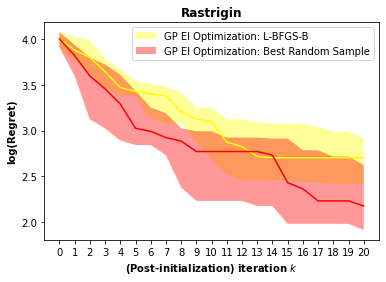

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI Optimization: L-BFGS-B')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP EI Optimization: Best Random Sample')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(93.10612654685974, 33.37443733215332)